In [ ]:
#SimCLR Code based on https://github.com/sthalles/SimCLR/blob/master/simclr.py

In [1]:
import os
import shutil

import torch
import yaml


def save_checkpoint(state, is_best, filename='checkpoint.pth.tar'):
    torch.save(state, filename)
    if is_best:
        shutil.copyfile(filename, 'model_best.pth.tar')


def save_config_file(model_checkpoints_folder, args):
    if not os.path.exists(model_checkpoints_folder):
        os.makedirs(model_checkpoints_folder)
        with open(os.path.join(model_checkpoints_folder, 'config.yml'), 'w') as outfile:
            yaml.dump(args, outfile, default_flow_style=False)


def accuracy(output, target, topk=(1,)):
    """Computes the accuracy over the k top predictions for the specified values of k"""
    with torch.no_grad():
        maxk = max(topk)
        batch_size = target.size(0)

        _, pred = output.topk(maxk, 1, True, True)
        pred = pred.t()
        correct = pred.eq(target.view(1, -1).expand_as(pred))

        res = []
        for k in topk:
            correct_k = correct[:k].reshape(-1).float().sum(0, keepdim=True)
            res.append(correct_k.mul_(100.0 / batch_size))
        return res

In [6]:
import logging
import os
import sys

import torch
import torch.nn.functional as F
from torch.cuda.amp import GradScaler, autocast
from torch.utils.tensorboard import SummaryWriter
from tqdm import tqdm

torch.manual_seed(0)


class SimCLR(object):

    def __init__(self,train_loader):
        self.backbone = torchvision.models.resnet18(pretrained = True)
        dim_mlp = self.backbone.fc.in_features
        # add mlp projection head
        self.backbone.fc = nn.Sequential(nn.Linear(dim_mlp, dim_mlp), nn.ReLU(), self.backbone.fc)
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.model = self.backbone.to(self.device)

        self.optimizer = optim.Adam(self.model.parameters(), lr=0.001)

        self.scheduler = torch.optim.lr_scheduler.CosineAnnealingLR(self.optimizer, T_max=len(train_loader), eta_min=0,
                                                           last_epoch=-1)
        self.writer = SummaryWriter()
        logging.basicConfig(filename=os.path.join(self.writer.log_dir, 'training.log'), level=logging.DEBUG)
        self.criterion = torch.nn.CrossEntropyLoss().to(self.device)
        #Should be the same with dataloaders batch size
        self.batch_size = 112
        self.n_views = 2
        self.temperature = 0.5
        self.epochs = 200
    def info_nce_loss(self, features):

        labels = torch.cat([torch.arange(self.batch_size) for i in range(self.n_views)], dim=0)
        labels = (labels.unsqueeze(0) == labels.unsqueeze(1)).float()
        labels = labels.to(self.device)

        features = F.normalize(features, dim=1)

        similarity_matrix = torch.matmul(features, features.T)
        

        # discard the main diagonal from both: labels and similarities matrix
        mask = torch.eye(labels.shape[0], dtype=torch.bool).to(self.device)
        labels = labels[~mask].view(labels.shape[0], -1)
        similarity_matrix = similarity_matrix[~mask].view(similarity_matrix.shape[0], -1)

        # select and combine multiple positives
        positives = similarity_matrix[labels.bool()].view(labels.shape[0], -1)

        # select only the negatives the negatives
        negatives = similarity_matrix[~labels.bool()].view(similarity_matrix.shape[0], -1)

        logits = torch.cat([positives, negatives], dim=1)
        labels = torch.zeros(logits.shape[0], dtype=torch.long).to(self.device)

        logits = logits / self.temperature
        return logits, labels

    def train(self, train_loader):

        scaler = GradScaler(enabled=False)

        n_iter = 0
        logging.info(f"Start SimCLR training for {self.epochs} epochs.")
        logging.info(f"Training with gpu: {False}.")

        for epoch_counter in range(self.epochs):
            running_loss = 0
            count = 0
            for images, _ in tqdm(train_loader):
                images = torch.cat(images, dim=0)

                images = images.to(self.device)

                with autocast(enabled=False):
                    features = self.model(images)
                    logits, labels = self.info_nce_loss(features)
                    loss = self.criterion(logits, labels)
                    running_loss += loss.mean().item()
                    count+=1
                self.optimizer.zero_grad()

                scaler.scale(loss).backward()

                scaler.step(self.optimizer)
                scaler.update()

                if n_iter % 20 ==0 :
                    top1, top5 = accuracy(logits, labels, topk=(1, 5))
                    print('Epoch : ',epoch_counter, ' Iter : ',n_iter)
                    print('Loss : ',loss.mean().item())
                    print('acc/top1 : ',top1[0].item())
                    print('acc/top5 : ',top5[0].item())
                    self.writer.add_scalar('loss', loss, global_step=n_iter)
                    self.writer.add_scalar('acc/top1', top1[0], global_step=n_iter)
                    self.writer.add_scalar('acc/top5', top5[0], global_step=n_iter)
                    self.writer.add_scalar('learning_rate', self.scheduler.get_lr()[0], global_step=n_iter)

                n_iter += 1
            print('Epoch ',epoch_counter,' loss :',running_loss/count)
            # warmup for the first 10 epochs
            if epoch_counter >= 10:
                self.scheduler.step()
            logging.debug(f"Epoch: {epoch_counter}\tLoss: {loss}\tTop1 accuracy: {top1[0]}")

        logging.info("Training has finished.")
        # save model checkpoints
        checkpoint_name = 'checkpoint_{:04d}.pth.tar'.format(self.epochs)
        save_checkpoint({
            'epoch': self.epochs,
            'arch': 'ResNet18',
            'state_dict': self.model.state_dict(),
            'optimizer': self.optimizer.state_dict(),
        }, is_best=False, filename=os.path.join(self.writer.log_dir, checkpoint_name))
        logging.info(f"Model checkpoint and metadata has been saved at {self.writer.log_dir}.")

In [7]:

import cv2 as cv
import numpy as np
import torch
# import torchvision
from torch import nn
from PIL import Image
import random
import albumentations as A
# Set random seed for reproducibility
manualSeed = 999
#manualSeed = random.randint(1, 10000) # use if you want new results
print("Random Seed: ", manualSeed)
random.seed(manualSeed)
torch.manual_seed(manualSeed)
class Dataset(torch.utils.data.Dataset):
    def __init__(self, dataset='../Data/Dataset', setting='train', gray=False,day = False, sim = True, original = False):
        self.path = dataset
        self.classes = os.listdir(self.path)
        self.day = day
        self.interferograms = []
        self.interferograms_normal = []
        self.interferograms_deformation = []
        self.ones_days = []
        self.zero_days = []
        self.sim = sim
        self.original = original
        for data_class in self.classes:
            images = os.listdir(self.path + '/' + data_class)
            for image in images:
                
                days = 0
                image_dict = {'path': self.path + '/' + data_class + '/' + image, 'label': data_class, 'days':days}
                self.interferograms.append(image_dict)
                if int(data_class)==0:
                    self.zero_days.append(days)
                    self.interferograms_normal.append(image_dict)
                else:
                    self.interferograms_deformation.append(image_dict)
                    self.ones_days.append(days)
        
        self.num_examples = len(self.interferograms)
        self.set = setting

    def __len__(self):
        return self.num_examples

    def __getitem__(self, index):
        if self.set == 'train' and self.sim==False:
          choice = random.randint(0,10)

          if choice %2 != 0:
              choice_normal = random.randint(0,len(self.interferograms_normal)-1)
              image_data = self.interferograms_normal[choice_normal]
          else:
              choice_deform = random.randint(0,len(self.interferograms_deformation)-1)
              image_data = self.interferograms_deformation[choice_deform]
        else:
          image_data = self.interferograms[index]
        image_file = image_data['path']
        image_label = image_data['label']
        image = cv.imread(image_file)
        zero = np.zeros_like(image)
        if image is None:
            print(image_file)    
        gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
        original = image
        original = original[:224,:224,:]
        zero[:,:,0] = gray
        zero[:,:,1] = gray
        zero[:,:,2 ] = gray
        image = zero
        image = image[:224, :224, :]
        if self.set == 'none':
            angle = random.randint(0, 360)

            M = cv.getRotationMatrix2D((113, 113), angle, 1)
            image = cv.warpAffine(image, M, (image.shape[1], image.shape[0]))

        if self.set == 'train':
          transform = A.Compose([
                A.augmentations.transforms.HorizontalFlip(p=0.8),
                A.augmentations.transforms.VerticalFlip(p=0.8),
                A.augmentations.transforms.ElasticTransform(p=0.8),
                A.augmentations.transforms.Cutout(p=0.8),
                A.augmentations.transforms.MultiplicativeNoise(p=0.8),
                A.augmentations.transforms.GaussianBlur(p=0.8),
                A.augmentations.transforms.GaussNoise(p=0.8)
            ])
          transformed = transform(image= image)
          augmented = transformed['image']
          
          sim = self.sim  
          if sim == True:
              transform2 = A.Compose([
                    A.augmentations.transforms.HorizontalFlip(p=0.8),
                    A.augmentations.transforms.VerticalFlip(p=0.8),
                    A.augmentations.transforms.ElasticTransform(p=0.8),
                    A.augmentations.transforms.Cutout(p=0.8),
                    A.augmentations.transforms.MultiplicativeNoise(p=0.8),
                    A.augmentations.transforms.GaussianBlur(p=0.8),
                    A.augmentations.transforms.GaussNoise(p=0.8)
                ])
              transformed2 = transform2(image=image)
              image = transformed2['image']
              flag = True
          
        else:
          
          augmented = None
          
          flag = False
 
        image = torch.from_numpy(image).float().permute(2,0,1)
        original = torch.from_numpy(original).float().permute(2,0,1)
        
        image = torchvision.transforms.Normalize((127.0710,127.0710,127.0710), (71.4902,71.4902,71.4902))(image)
        if augmented is None:
            augmented = torch.tensor(int(image_label))
        else:
            augmented = torch.from_numpy(augmented).float().permute(2,0,1)
            #merged
            augmented = torchvision.transforms.Normalize((127.0710,127.0710,127.0710), (71.4902,71.4902,71.4902))(augmented)
            
        if image.shape[1]<224 or image.shape[2]<224:
            print(image_file)
        if self.original:
            return (image,augmented,original),int(image_label), image_file
        return (image, augmented), int(image_label)



Random Seed:  999


In [8]:
import os

data_dir = 'S1/Train'
test_dir = 'S1/Test'


In [24]:
import torchvision
import torch.optim as optim
#For SimcLR Training sim = True. For finetuning sim = False
train_dataset = Dataset(data_dir,setting='train',sim=True)
val_dataset =  Dataset(test_dir,setting='test',original=False)



train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=112, shuffle=True, num_workers=1, drop_last = True)

testloader = torch.utils.data.DataLoader(val_dataset, batch_size=112, shuffle=True, num_workers=1, drop_last = False) 

In [12]:
import torchvision
import torch.optim as optim

simclr = SimCLR(train_loader)
simclr.train(train_loader)

  1%|▏         | 1/67 [00:06<07:17,  6.63s/it]

Epoch :  0  Iter :  0
Loss :  5.307097911834717
acc/top1 :  5.8035712242126465
acc/top5 :  16.51785659790039


 31%|███▏      | 21/67 [02:14<04:53,  6.38s/it]

Epoch :  0  Iter :  20
Loss :  4.281856060028076
acc/top1 :  19.64285659790039
acc/top5 :  42.85714340209961


 61%|██████    | 41/67 [04:24<02:51,  6.59s/it]

Epoch :  0  Iter :  40
Loss :  4.119046211242676
acc/top1 :  29.91071319580078
acc/top5 :  58.92856979370117


 91%|█████████ | 61/67 [06:34<00:39,  6.54s/it]

Epoch :  0  Iter :  60
Loss :  4.0083088874816895
acc/top1 :  29.91071319580078
acc/top5 :  61.60714340209961


  0%|          | 0/67 [00:00<?, ?it/s]

Epoch  0  loss : 4.22724743743441


 21%|██        | 14/67 [01:30<05:46,  6.53s/it]

Epoch :  1  Iter :  80
Loss :  4.0192694664001465
acc/top1 :  28.125
acc/top5 :  59.82142639160156


 51%|█████     | 34/67 [03:39<03:26,  6.27s/it]

Epoch :  1  Iter :  100
Loss :  3.9596517086029053
acc/top1 :  41.51785659790039
acc/top5 :  67.41071319580078


 81%|████████  | 54/67 [05:48<01:25,  6.61s/it]

Epoch :  1  Iter :  120
Loss :  3.9960665702819824
acc/top1 :  31.696428298950195
acc/top5 :  61.60714340209961


100%|██████████| 67/67 [07:13<00:00,  6.47s/it]


Epoch  1  loss : 3.962418919178977


In [13]:
torch.save(simclr.model.state_dict(), 'ModelSimclr.pt')

In [ ]:
print(simclr.model)

In [25]:
#For SimcLR Training sim = True. For finetuning sim = False
train_dataset = Dataset(data_dir,setting='train',sim=False)
val_dataset =  Dataset(test_dir,setting='test',original=False)




uniqueDataset = Dataset('ClearDataset/Train', setting='train')
uniqueloader = torch.utils.data.DataLoader(uniqueDataset, batch_size=1, shuffle=False, num_workers=1) 

In [26]:
import torch
torch.manual_seed(999)

simclr = SimCLR(train_loader)
model_path = 'ModelSimclr.pt'#'YOUR_MODEL_PATH' 
simclr.model.load_state_dict(torch.load(model_path))

simclr.model.fc = nn.Identity()
for param in simclr.model.parameters():
    param.requires_grad = False


model = simclr.model

model.fc = nn.Linear(512,2)

model.to(simclr.device)
print(simclr.device)
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=1000, gamma=0.1)

device = simclr.device

for epoch in range(1):

    running_loss = 0.0
    model.train()
    correct = 0
    total = 0
    for i, ((inputs,_), labels) in enumerate(train_loader):
        # get the inputs; data is a list of [inputs, labels]
        
        # zero the parameter gradients
        optimizer.zero_grad()
        
        # forward + backward + optimize
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        _, predicted = torch.max(outputs.data, 1)
        
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        # print statistics
        running_loss += loss.item()
        
        if i % 20 == 0:    # print every 2000 mini-batches
            print('[%d, %5d] loss: %.5f' %
                  (epoch + 1, i + 1, running_loss / 20))
            running_loss = 0.0
            print('Accuracy of the network on the trainin images: %d %%' % (
            100 * correct / total))
    correct = 0
    total = 0
    model.eval()
    scheduler.step()
    with torch.no_grad():
        for data in testloader:
            (images,_), labels = data
            images = images.to(device)
            labels = labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()
            print('Labels')
            print(labels)
            print('Predicted')
            print(predicted)
    print('Accuracy of the network on the test images: %d %%' % (
        100 * correct / total))


print('Finished Training')


cuda
[1,     1] loss: 0.04734
Accuracy of the network on the trainin images: 32 %
[1,    21] loss: 0.17499
Accuracy of the network on the trainin images: 93 %
[1,    41] loss: 0.10426
Accuracy of the network on the trainin images: 95 %
[1,    61] loss: 0.06709
Accuracy of the network on the trainin images: 96 %
Labels
tensor([0, 1, 0, 0, 0, 1, 0, 1, 1, 1, 1, 0, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 1, 0,
        0, 0, 0, 1, 1, 0, 0, 1, 0, 0, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 1,
        1, 0, 1, 1, 0, 1, 0, 1, 0, 1, 1, 1, 0, 0, 0, 1], device='cuda:0')
Predicted
tensor([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
        0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], device='cuda:0')
Accuracy of the network on the test images: 50 %
Finished Training


In [ ]:
!pip install --user torchcam

In [19]:

import matplotlib.pyplot as plt

def cam(file_path):
  model.to('cpu')
  import math
  from torchvision.transforms.functional import to_pil_image
  from torchcam.utils import overlay_mask

  gradcam = True
  if gradcam:

      from torchcam.cams import SmoothGradCAMpp, CAM, GradCAM, ScoreCAM, GradCAMpp, SSCAM, ISCAM
      image = cv.imread(file_path)
      zero = np.zeros_like(image)
      gray = cv.cvtColor(image, cv.COLOR_BGR2GRAY)
      zero[:,:,0] = gray
      zero[:,:,1] = gray
      zero[:,:,2 ] = gray
      image = zero

      img =  image 
      img = img[:224,:224,:]
      pil_img = Image.fromarray(img)

      img = torch.from_numpy(img).float().permute(2,0,1).unsqueeze(dim=0)
      print(img.shape)
      img_tensor = torchvision.transforms.Normalize((127.0710,127.0710,127.0710), (71.4902,71.4902,71.4902))(img)

      # Hook the corresponding layer in the model
      cam_extractors = [
          CAM(model,fc_layer='fc'),
         
      ]

      # Don't trigger all hooks
      for extractor in cam_extractors:
          extractor._hooks_enabled = False

      num_rows = 2
      num_cols = math.ceil(len(cam_extractors) / num_rows)
      
      class_idx = None
      for idx, extractor in enumerate(cam_extractors):
          extractor._hooks_enabled = True
          model.zero_grad()
          scores = model(img_tensor)

          # Select the class index
          class_idx = scores.squeeze(0).argmax().item() if class_idx is None else class_idx
          print(class_idx)
          # Use the hooked data to compute activation map
          activation_map = extractor(class_idx, scores).cpu()

          # Clean data
          extractor.clear_hooks()
          extractor._hooks_enabled = False
          # Convert it to PIL image
          # The indexing below means first image in batch
          heatmap = to_pil_image(activation_map, mode='F')
          # Plot the result
          result = overlay_mask(pil_img, heatmap)
          plt.imshow(result)
          
          plt.title(extractor.__class__.__name__)
      
      plt.tight_layout()
      if True:
          plt.savefig('result'+str(idx) ,dpi=200, transparent=True, bbox_inches='tight', pad_inches=0)
      plt.show()


In [27]:
#Evaluate
test = Dataset('C1', setting='train',sim=False,original=True)
testloader = torch.utils.data.DataLoader(test, batch_size=1, shuffle=False, num_workers=1,drop_last=False) 

In [21]:
import matplotlib.pyplot as plt


769
Accuracy of the network on the test images: 43 %
Finished Training
Correct :  338
Total :  769
False Positives :  0
True Positives:  0
False Negatives :  431
True Negatives :  338


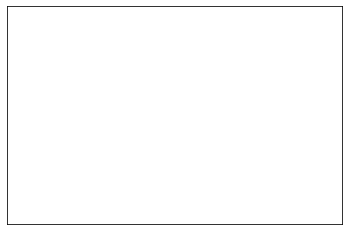

In [28]:
import torch
import matplotlib
import kornia

torch.manual_seed(999)

verbose = False

device = simclr.device

correct = 0
total = 0
model.to(device)
model.eval()
false_positives = 0
total_negatives = 0
false_negatives = 0
true_positives = 0 
true_negatives = 0
print(len(testloader.dataset))

with torch.no_grad():
    for i,data in enumerate(testloader):
        (images,augm,original), labels, path = data

        images = images.to(device)
        labels = labels.to(device)
        outputs = model(images)
        _, predicted = torch.max(outputs.data, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        
        plt.tick_params(
            axis='both',          # changes apply to the x-axis
            #which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False,
            labelleft=False,
            left=False,
            )
        if verbose:
            plt.imshow(images.cpu().detach().squeeze().numpy().transpose(1,2,0)/255)
            score = nn.Softmax()(outputs).max().item()
            
            plt.show()
            plt.tick_params(
            axis='both',          # changes apply to the x-axis
            #which='both',      # both major and minor ticks are affected
            bottom=False,      # ticks along the bottom edge are off
            top=False,         # ticks along the top edge are off
            labelbottom=False,
            labelleft=False,
            left=False,
            )
            plt.imshow(augm.cpu().detach().squeeze().squeeze().numpy().transpose(1,2,0)/255)
            plt.show()

        total_negatives += (labels==0).sum().item()
        false_positives += (predicted[labels==0] == 1).sum().item()
        false_negatives += (predicted[labels==1] == 0).sum().item()
        true_positives += (predicted[labels==1] == 1).sum().item()
        true_negatives += (predicted[labels==0] == 0).sum().item()
        
print('Accuracy of the network on the test images: %d %%' % (
    100 * correct / total))


print('Finished Training')
print('Correct : ',correct)
print('Total : ', total)
print('False Positives : ',false_positives)
print('True Positives: ', true_positives)
print('False Negatives : ',false_negatives)
print('True Negatives : ', true_negatives)


# cam('test3Cropped/1/20210217_20210301.geo.diff.png')

torch.Size([1, 3, 224, 224])
0


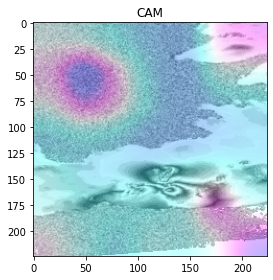

In [23]:
cam('C1/1/iceland_d_20201020_20201119.geo.diff1_2.png')